In [1]:
!pip install "gluonts[torch]"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
AIRLINES_CSV_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
TS_COLUMN = "Passengers"

ts_data = pd.read_csv(AIRLINES_CSV_URL, index_col=0, parse_dates=True)
ts_data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
train_size = int(len(ts_data) * 0.8)
test_size = len(ts_data) - train_size

dataset = PandasDataset(ts_data, target=TS_COLUMN)

forecast = 1
windows = int(test_size / forecast)

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(
    prediction_length=forecast, windows=windows
)

In [6]:
model = DeepAREstimator(
    prediction_length=forecast, freq="M", trainer_kwargs={"max_epochs": 15}
).train(training_data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                                  | Out sizes  
-----------------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 6.71184 (best 6.71184), saving model to '/content/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 6.71184 (best 6.71184), saving model to '/content/lightning_logs/version_8/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 5.29840 (best 5.29840), saving model to '/content/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 5.29840 (best 5.29840), saving model to '/content/lightning_logs/version_8/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 4.67057 (best 4.67057), saving model to '/content/lightning_logs/version_8/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: '

In [7]:
fcast = list(model.predict(test_data.input))
test_outputs = np.array([x.samples.mean(axis=0) for x in fcast]).reshape(-1)
test_stds = np.array([x.samples.std(axis=0) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(test_outputs, ts_data.iloc[train_size:].values)
)

print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 27.3965


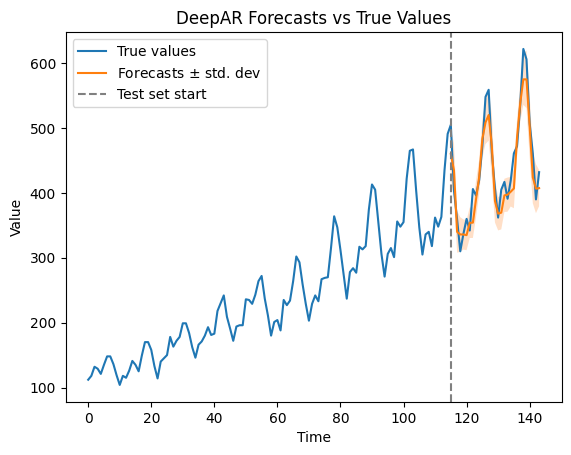

In [8]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_stds = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_stds = np.concatenate((train_stds, test_stds))

test_start_index = len(ts_data) - test_size

plt.plot(ts_data[TS_COLUMN].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ std. dev",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_stds,
    all_outputs + all_stds,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("DeepAR Forecasts vs True Values")
plt.show()

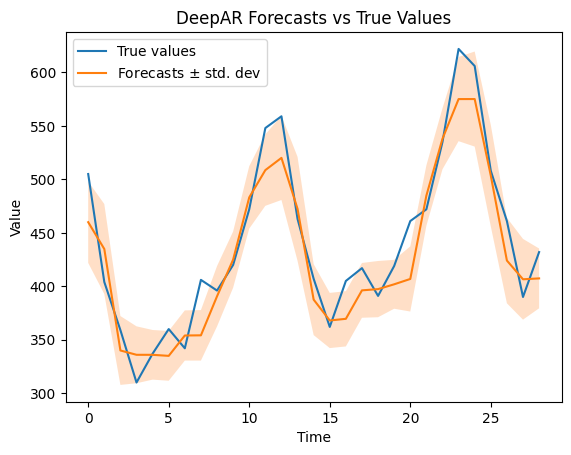

In [9]:
plt.plot(ts_data[TS_COLUMN].values[train_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ std. dev",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_stds,
    test_outputs + test_stds,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("DeepAR Forecasts vs True Values")
plt.show()